# JEC profile plots

Poor man's coffea 0.7.1 mix of https://github.com/cms-jet/CoffeaJERC/blob/master/genL2L3.ipynb and [nanoevents.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/nanoevents.ipynb) to illustrate profile plots

In [1]:
import awkward as ak
import numpy as np
import time
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

fname = "step1_NANO_NoClusterThreshold_ButOnlyGenMatchBelow5GeV_54.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

In [2]:
from coffea import processor, hist
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        dr_axis = hist.Bin("dr", r"$\delta (\eta)$", 20, 0., 1)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        r_axis = hist.Bin("r", "RECO / GEN response", 200, 0, 5)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'r_pt_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptvm':hist.Hist("Counts", dataset_axis, pt_axis, m_axis, r_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        output['cutflow']['all events'] += len(events)
        #print(len(events))
        
        selectedEvents = events[
            (ak.num(events.Jet) > 2)
        ]

        #leading jet
        #print(selectedEvents.Jet[:,0])
        #leading two jets
        jet = selectedEvents.Jet[:,0:2]
        jet = ak.flatten(jet)
        #only with genmatch
        jet = jet[~ak.is_none(jet.matched_gen)]
        #only with good deltaR match
        jet = jet[jet.delta_r(jet.matched_gen)<0.2]
        
        ptresponse = jet.pt/jet.matched_gen.pt
        
        output['dr'].fill(dataset=selectedEvents.metadata["dataset"],
                            dr=jet.delta_r(jet.matched_gen))
        output['pt'].fill(dataset=selectedEvents.metadata["dataset"],
                            pt=jet.pt)
        output['eta'].fill(dataset=selectedEvents.metadata["dataset"], 
                                 eta=jet.eta)
        output['r_pt_ptveta'].fill( dataset=selectedEvents.metadata["dataset"], pt=jet.pt, eta=jet.eta, r=ptresponse)
        
        return output

    def postprocess(self, accumulator):
        return accumulator
   

In [3]:
samples = {
    "QCDFlat": [fname]
}
tstart = time.time() 
result = processor.run_uproot_job(
    samples,
    "Events",
    FancyJECL2L3Processor(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
)
elapsed = time.time() - tstart
print(result)
print("Events/s:", result['cutflow']['all events']/elapsed)


{'pt': <Hist (dataset,pt) instance at 0x7f6e7bbd7bb0>, 'eta': <Hist (dataset,eta) instance at 0x7f6e79c27640>, 'dr': <Hist (dataset,dr) instance at 0x7f6e79c27b50>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6e79c27b80>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f6e79c27bb0>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f6e79c27be0>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 84900})}
Events/s: 8018.158680307206


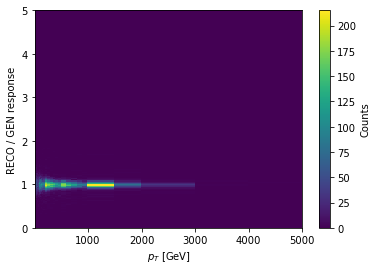

In [4]:
ax = hist.plot2d(result['r_pt_ptveta'].sum('dataset').integrate('eta', result['r_pt_ptveta'].axis('eta')[10]),xaxis='pt')


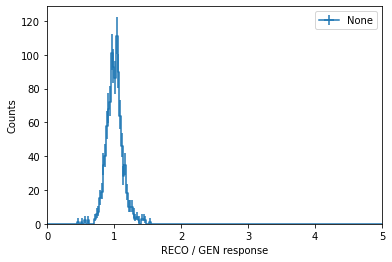

In [7]:
ax = hist.plot1d(result['r_pt_ptveta'].sum('dataset').integrate('eta', result['r_pt_ptveta'].axis('eta')[10]).integrate('pt',result['r_pt_ptveta'].axis('pt')[15]))

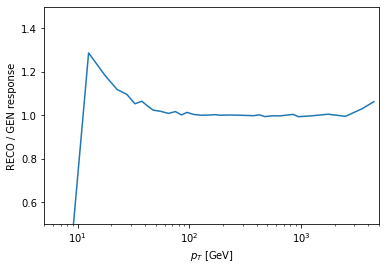

In [8]:
h = result['r_pt_ptveta'].sum('dataset').integrate('eta', result['r_pt_ptveta'].axis('eta')[10])
xaxis='pt'
xaxis = h.axis(xaxis)
yaxis = h.axes()[1]
xoverflow='none'
xedges = xaxis.edges(overflow=xoverflow)
xcenters = xaxis.centers(overflow=xoverflow)
vals = list(h.values().values())

avs = [np.average(h.axes()[1].centers(), weights=b) if np.sum(b)>0 else 0. for b in vals[0]]
#dummy
avs_err = [0.]*len(avs)


import mplhep as hep
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)


ax.set_xlabel(xaxis.label)
ax.set_ylabel(yaxis.label)
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(0.5, 1.5)

errbar = ax.errorbar(x=xcenters, y=avs, yerr=avs_err)
plt.xscale("log")



Would be awesome to have a kind of projection function that gives "profile plots", e.g. 
* showing arithmetic mean +/- error, 
* median +/- errror (or interquartile range), 
* mode (e.g. from a Gaussian fit)
* violin plots etc.